In [1]:
import pandas as pd
import socket, struct
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import re

### Loading the dataset

In [2]:
traffic = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Kaggle/*.csv')], ignore_index = True)
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300825 entries, 0 to 2300824
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

The next function is used to lower the memory usage of the dataset, since many of the columns are using the large types, and many of them don't need to ocupy that many bytes.

In [3]:
""" Receives a datase, checks the type of each column and if the value fits in a smaller type it changes it to that type"""
def convert_types(data):
    for column in data.columns:
        if data[column].dtype == np.int64:
            max_val = data[column].max()
            if max_val < 127:
                data[column] = data[column].astype(np.int8)
            elif max_val < 32767:
                data[column] = data[column].astype(np.int16)
            else:
                data[column] = data[column].astype(np.int32)
            
        if data[column].dtype == np.float64:
            data[column] = data[column].astype(np.float32)

We can see that with the new types the memory usage lowers to around 1/3 of what it used with the original types

In [12]:
convert_types(traffic)
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019730 entries, 0 to 2019729
Data columns (total 69 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int32  
 1   Flow Duration                int32  
 2   Total Fwd Packets            int32  
 3   Total Backward Packets       int32  
 4   Total Length of Fwd Packets  int32  
 5   Total Length of Bwd Packets  int32  
 6   Fwd Packet Length Max        int16  
 7   Fwd Packet Length Min        int16  
 8   Fwd Packet Length Mean       float32
 9   Fwd Packet Length Std        float32
 10  Bwd Packet Length Max        int16  
 11  Bwd Packet Length Min        int16  
 12  Bwd Packet Length Mean       float32
 13  Bwd Packet Length Std        float32
 14  Flow IAT Mean                float32
 15  Flow IAT Std                 float32
 16  Flow IAT Max                 int32  
 17  Flow IAT Min                 int32  
 18  Fwd IAT Total                int32  
 19  

### Cleaning the dataset

In [13]:
# Check for missing data
print(f"Missing values: {traffic.isnull().sum().sum()}")

# Check for infinite values, replace with NAN so it is easy to remove them
traffic.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {traffic.isnull().sum().sum()}")


Missing values: 0
Missing values: 0


In [14]:
""" 
    Function that receives the dataset and reformats the names of the columns, removing the spaces in the beginning
    of the name.
"""
def reformat_names(data):
    for column_name in data.columns:
        data.rename(columns = {column_name : column_name.lstrip()}, inplace = 'False')
    return data
        
""" 
    Function that receives the dataset and removes invalid rows (inf, -inf, nan or ",,")
"""
def remove_invalid_rows(data):
    deleteCol = []
    for column in data.columns:
        if data[column].isnull().values.any():
            deleteCol.append(column)
    for column in deleteCol:
        data.drop([column],axis=1,inplace=True)
    return data

In [15]:
traffic = reformat_names(traffic)
traffic = remove_invalid_rows(traffic)

In [16]:
# Check for missing data
print(f"Missing values: {traffic.isnull().sum().sum()}")

# Check for infinite values, replace with NAN so it is easy to remove them
traffic.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Missing values: {traffic.isnull().sum().sum()}")

Missing values: 0
Missing values: 0


Here we find and remove the features that only have one value and the duplicate rows, since they are irrelevant for the learning process of the ML algorithms

In [17]:
""" 
    Function that receives the dataset, checks for columns that have only one value and drops them from the dataset.
    After it checks for duplicate rows and also drops them.
    
    Returns the dataset modified
"""
def drop_irr_features(data):
    drop_list = data.columns[data.nunique() <= 1].to_list()
    print("List of columns to be dropped")
    print(drop_list)
    data = data.drop(labels = drop_list, axis = 1)
    data =  data.drop_duplicates(keep="first")
    data.reset_index(drop=True,inplace=True)
    return data

In [18]:
traffic=drop_irr_features(traffic)

List of columns to be dropped
[]


In [19]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019730 entries, 0 to 2019729
Data columns (total 69 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int32  
 1   Flow Duration                int32  
 2   Total Fwd Packets            int32  
 3   Total Backward Packets       int32  
 4   Total Length of Fwd Packets  int32  
 5   Total Length of Bwd Packets  int32  
 6   Fwd Packet Length Max        int16  
 7   Fwd Packet Length Min        int16  
 8   Fwd Packet Length Mean       float32
 9   Fwd Packet Length Std        float32
 10  Bwd Packet Length Max        int16  
 11  Bwd Packet Length Min        int16  
 12  Bwd Packet Length Mean       float32
 13  Bwd Packet Length Std        float32
 14  Flow IAT Mean                float32
 15  Flow IAT Std                 float32
 16  Flow IAT Max                 int32  
 17  Flow IAT Min                 int32  
 18  Fwd IAT Total                int32  
 19  

Highly correlated features are some what linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost, so we can drop them from the dataset.

In [20]:
"""
    Function that receives the dataset and calculates de correlated matrix.
    
    Correlation matrix will be mirror  image about the diagonal and all the diagonal elements will be 1. 
    So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix. 
    After selecting the upper tringular, if the correlation in any of those features are greater than 0.90 we will 
    select it to be dropped. 
    
    Returns a list of features to be dropped
"""
def get_correlated_features(data):   
    correlated_matrix = traffic.corr().abs()
    print(correlated_matrix)
    upper_tri = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(bool))
    print(upper_tri)
    drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.90)]
    return drop

In [21]:
drop_list = get_correlated_features(traffic)
print(drop_list)
traffic = traffic.drop(labels = drop_list, axis = 1)

                             Destination Port  Flow Duration  \
Destination Port                     1.000000       0.166036   
Flow Duration                        0.166036       1.000000   
Total Fwd Packets                    0.004568       0.020011   
Total Backward Packets               0.004264       0.018717   
Total Length of Fwd Packets          0.017651       0.057785   
...                                       ...            ...   
Active Min                           0.022240       0.118093   
Idle Mean                            0.125663       0.781264   
Idle Std                             0.016718       0.242940   
Idle Max                             0.120088       0.793421   
Idle Min                             0.128605       0.750566   

                             Total Fwd Packets  Total Backward Packets  \
Destination Port                      0.004568                0.004264   
Flow Duration                         0.020011                0.018717   
Total Fwd

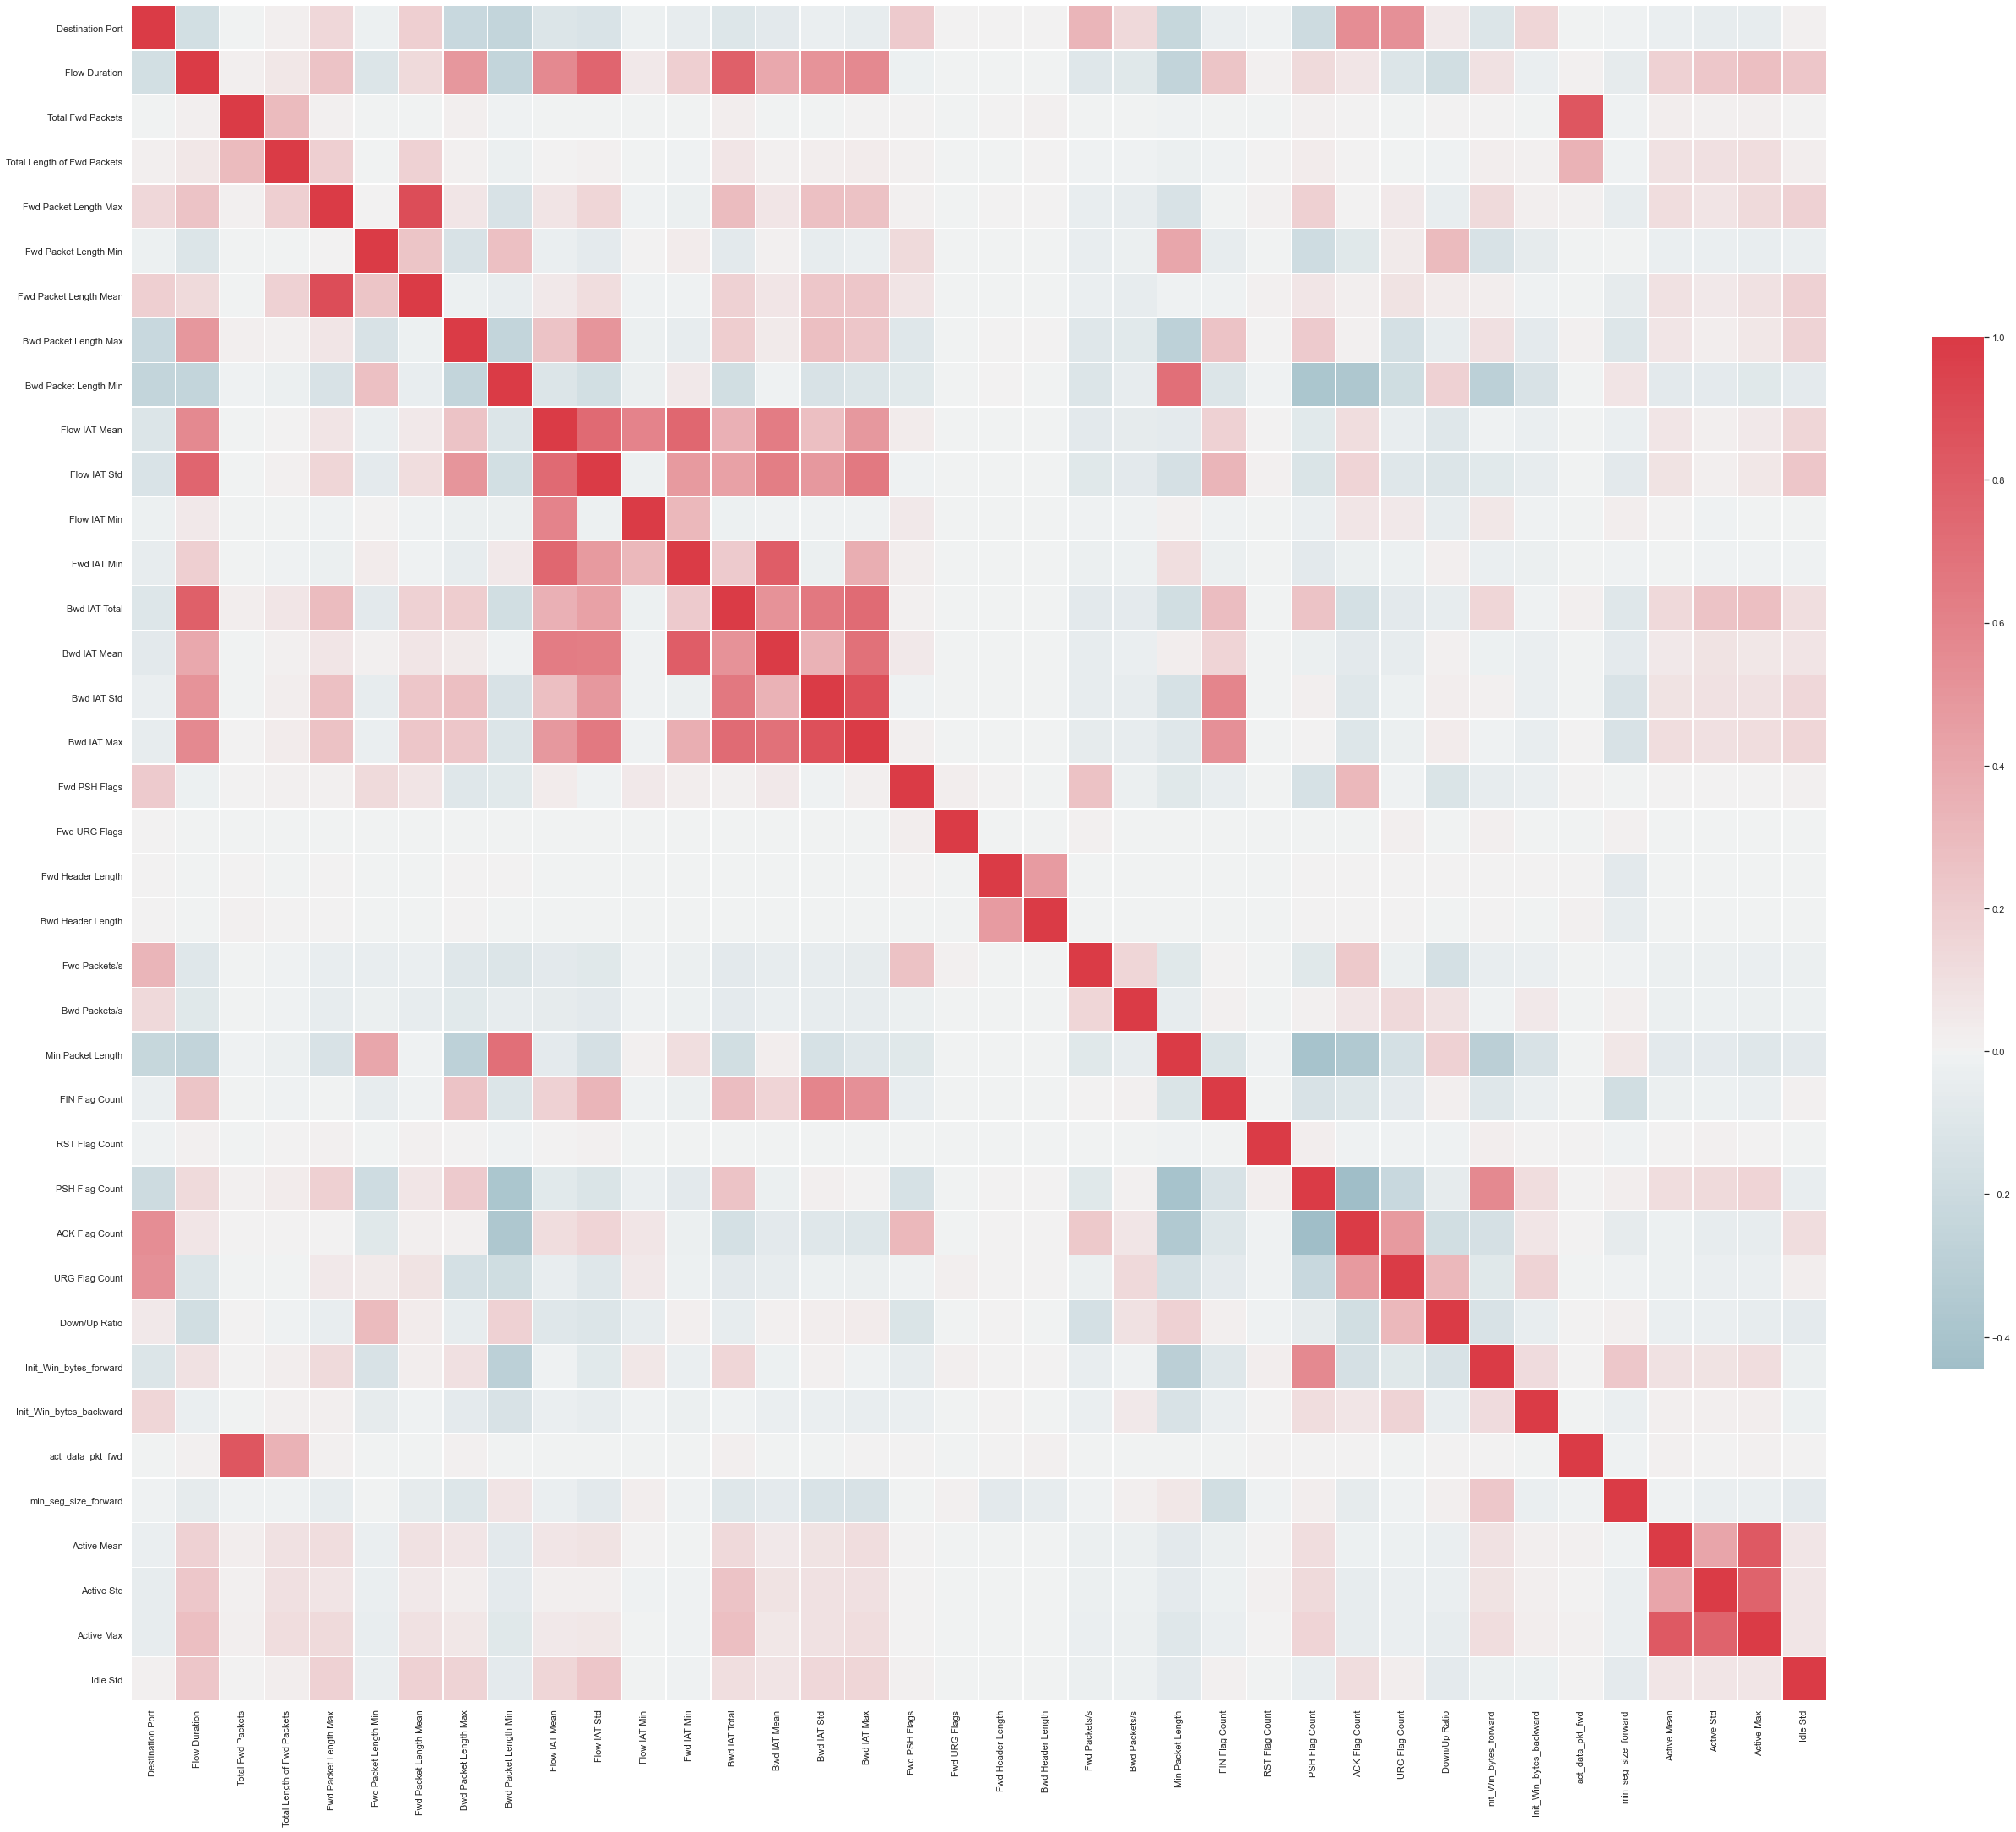

In [22]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = traffic.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(45,45))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False);

Now we will check the Label column, and see its normalized values

In [23]:
traffic.Label.value_counts(normalize=True)

BENIGN                        0.789141
DoS Hulk                      0.085580
DDoS                          0.063383
PortScan                      0.044966
DoS GoldenEye                 0.005093
FTP-Patator                   0.002938
DoS slowloris                 0.002666
DoS Slowhttptest              0.002588
SSH-Patator                   0.001594
Bot                           0.000967
Web Attack � Brute Force      0.000728
Web Attack � XSS              0.000323
Infiltration                  0.000018
Web Attack � Sql Injection    0.000010
Heartbleed                    0.000005
Name: Label, dtype: float64

As we can see there are some features that can me merged because they are similar (Web Attacks and DoS)

In [24]:
# merging similar classes with low instances
web_attack = traffic.Label.replace(["Web Attack � Brute Force","Web Attack � XSS","Web Attack � Sql Injection"],"Web Attack")
pd.options.mode.chained_assignment = None  # default='warn'
traffic.Label = web_attack

dos = traffic.Label.replace(["DoS Hulk","DoS GoldenEye","DoS slowloris", "DoS Slowhttptest"], "DoS")
pd.options.mode.chained_assignment = None  # default='warn'
traffic.Label = dos
traffic.Label.value_counts(normalize=True)

BENIGN          0.789141
DoS             0.095928
DDoS            0.063383
PortScan        0.044966
FTP-Patator     0.002938
SSH-Patator     0.001594
Web Attack      0.001061
Bot             0.000967
Infiltration    0.000018
Heartbleed      0.000005
Name: Label, dtype: float64

In [25]:
traffic.to_csv('Data/Processed/processed_data.csv', index = False)